In [2]:
import torch
print(torch.__version__)

2.8.0+cpu


*setting up device*

In [3]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


*getting data*

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get(
            "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory exists.


**Become one with data (data preparation)**

*we can inspect what's inside our directory using `os.walk`

In [5]:
import os

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories, and {len(filenames)} images in {dirpath}")

print(walk_through_dir(image_path))    

There are 2 directories, and 0 images in data\pizza_steak_sushi
There are 3 directories, and 0 images in data\pizza_steak_sushi\test
There are 0 directories, and 25 images in data\pizza_steak_sushi\test\pizza
There are 0 directories, and 19 images in data\pizza_steak_sushi\test\steak
There are 0 directories, and 31 images in data\pizza_steak_sushi\test\sushi
There are 3 directories, and 0 images in data\pizza_steak_sushi\train
There are 0 directories, and 78 images in data\pizza_steak_sushi\train\pizza
There are 0 directories, and 75 images in data\pizza_steak_sushi\train\steak
There are 0 directories, and 72 images in data\pizza_steak_sushi\train\sushi
None


*setting up train, test directory*

In [6]:

train_dir=image_path/'train'
test_dir=image_path/'test'

print(train_dir)
print(test_dir)

data\pizza_steak_sushi\train
data\pizza_steak_sushi\test


*visualizing an image*

data\pizza_steak_sushi\test\sushi\2394442.jpg
sushi
408
512
(512, 408)


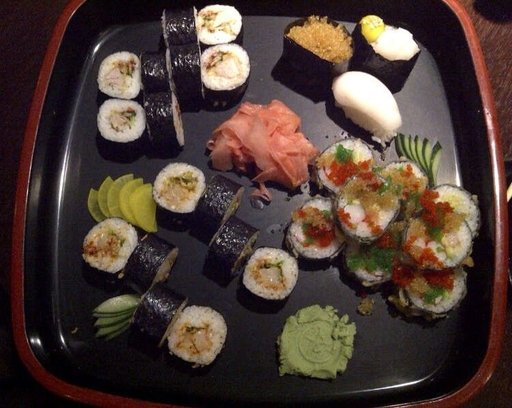

In [7]:
import random
from PIL import Image

random.seed(42)
image_path_list=list(image_path.glob("*/*/*.jpg")) # getting all the image path list
random_image_path=random.choice(image_path_list) # making a random choice from image path list
print(random_image_path)

random_image=Image.open(random_image_path) # opening random image
print(random_image_path.parent.stem) # parent directory of random image
print(random_image.height)
print(random_image.width)
print(random_image.size) # size of random image
random_image

*we can also do with `matplotlib.pyplot.imshow()`, for that `numpy` plays a crucial role

(408, 512, 3)


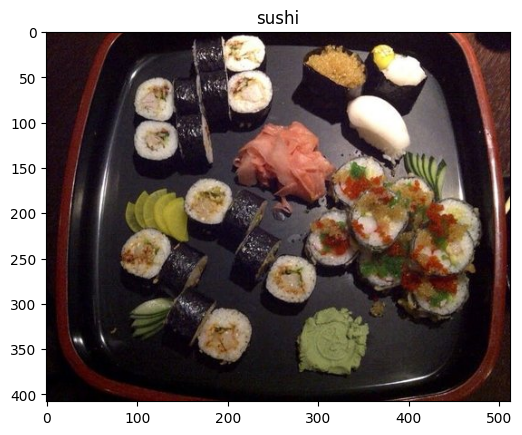

In [8]:
import matplotlib.pyplot as plt
import numpy as np
random_image_array=np.asarray(random_image)
plt.title(random_image_path.parent.stem) # from sushi class (directory)
print(random_image_array.shape) # [height, width, color_channel]
plt.imshow(random_image_array)

**Transforming Data**

For working with images with PyTorch, we need to trasnform images into tensor, in this case
`torchvision.trasnforms` helps a lot.

`torchvision.transforms` have many features which format images, turning them into tensors, manipulating them for **data augmentation** process, which is essential for training model.

There are number of steps, we need to remember to trasnform an image into tensors.
1. resize the image using `transforms.Resize()` into 64x64 shape
2. flipping the image `transforms.RandomHorizontalFlip()` (data augmentation step)
3. turning it into tensor `transforms.ToTensor()`

In [9]:
import torch
import torchvision
from torchvision import transforms

# for data trasnformation
data_transform=transforms.Compose([
    transforms.Resize(size=(32,32)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])



torch.Size([32, 32, 3])
sushi


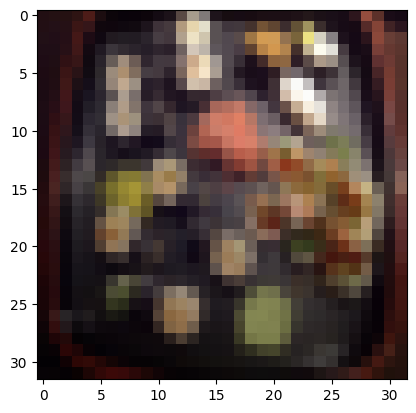

In [10]:
def plot_trasnformed_image(imgdata_transform,random_img_path):
    random.seed(42)
    random_img = Image.open(random_img_path)
    transformed_img=imgdata_transform(random_img).permute(1,2,0)
    print(transformed_img.shape)
    print(random_img_path.parent.stem)
    plt.imshow(transformed_img)

plot_trasnformed_image(imgdata_transform=data_transform,random_img_path=random_image_path)

    

**Loading image data using `ImageFolder`**

Let's turn out image data into `Dataset` capable of being used with PyTorch.
can be done with `torchvision.datasets.ImageFolder`

In [11]:
from torchvision import datasets

# making training data
train_data=datasets.ImageFolder(root=train_dir, # root of the training data directory
                                transform=data_transform, # transformation of data
                                target_transform=None # transforms to performs on label (if necessary)
                                )
# making testing data
test_data=datasets.ImageFolder(root=test_dir,
                               transform=data_transform,
                               target_transform=None
                               )

print(train_data)
print(test_data)


Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [12]:
# checking stuffs: 1
class_names=train_data.classes
print(class_names)

clas_dict=train_data.class_to_idx
print(clas_dict)

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [13]:
# checking stuffs: 2
img, label=train_data[0][0], train_data[0][1]
print(img.shape)
print(class_names[label])
print(len(train_data))
print(len(train_data.classes))

torch.Size([3, 32, 32])
pizza
225
3


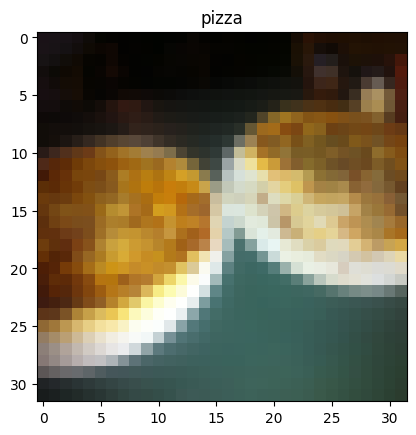

In [14]:
# printing an image with `matplotlib`

img_permute=img.permute(1,2,0)
plt.title(class_names[label])
plt.imshow(img_permute)

*at first, we created our images into `Dataset`, which is effective while working with `PyTorch`, 
now, turning `Datatset` into `Dataloader`, that make them iterable and learning effective for models.

In [15]:
from torch.utils.data import DataLoader
# train dataloader
train_dataloader=DataLoader(dataset=train_data,batch_size=10, # how many samples per batch
                            shuffle=True,
                            num_workers=1 # how many subprocess use for data loader? (higher = more)
                            )

# test dataloader
test_dataloader=DataLoader(dataset=test_data,batch_size=1, num_workers=1, shuffle=False)


print(train_dataloader)
print(test_dataloader)


In [16]:
# now our data is iterable, let's check it out
img_batch, label_batch=next(iter(train_dataloader))

print(img_batch.shape) # [batch, color_channel, height, width]
print(label_batch.shape)


torch.Size([10, 3, 32, 32])
torch.Size([10])


*making a model for predictions*

In [17]:
from torch import nn

class TinyVCG(nn.Module):
    def __init__(self, input_shape:int, output_shape:int, hidden_shape: int):
        super().__init__()
        # block 1
        self.conv_block_1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_shape, kernel_size=3, 
                      stride=1, # default
                      padding=1),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=hidden_shape, out_channels=hidden_shape, kernel_size=3, 
                      stride=1, # default
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)

        )
        # block 2
        self.conv_block_2=nn.Sequential(
            nn.Conv2d(in_channels=hidden_shape, out_channels=hidden_shape, kernel_size=3, 
                      stride=1, # default
                      padding=1),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=hidden_shape, out_channels=hidden_shape, kernel_size=3, 
                      stride=1, # default
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)

        )
        # block 3
        self.conv_block_3=nn.Sequential(
            nn.Conv2d(in_channels=hidden_shape, out_channels=hidden_shape, kernel_size=3, 
                      stride=1, # default
                      padding=1),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=hidden_shape, out_channels=hidden_shape, kernel_size=3, 
                      stride=1, # default
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)

        )

        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_shape*4*4, out_features=output_shape)
        )
    
    def forward(self, x:torch.tensor):
        x=self.conv_block_1(x)
        x=self.conv_block_2(x)
        x=self.conv_block_3(x)
        x=self.classifier(x)
        return x
    
torch.manual_seed(42)
model_1=TinyVCG(input_shape=3, # no of color channels
                hidden_shape=10,
                output_shape=len(train_data.classes)).to(device)
                

model_1

TinyVCG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_fea

*Trying a forward pass on a single image (to test the model)*

In [18]:
# taking single image from `img_batch` for testing
img_single=img_batch[0].unsqueeze(dim=0)
print(img_single.shape)
label_single=label_batch[0]

# performing `forward pass` on a single image
model_1.eval()
with torch.inference_mode():
    pred=model_1(img_single.to(device))

print(pred) # predictions (output logits)
print(torch.softmax(pred, dim=1)) # prediction probablities
print(torch.argmax(torch.softmax(pred, dim=1))) # prediction label
print(label_single)



torch.Size([1, 3, 32, 32])
tensor([[0.0321, 0.0340, 0.0170]])
tensor([[0.3348, 0.3354, 0.3298]])
tensor(1)
tensor(1)


*using `torchinfo` to get an idea of the shapes going through our model*

In [19]:

from torchinfo import summary
summary(model_1, input_size=[1,3,32,32])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVCG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 10, 32, 32]           280
│    └─ReLU: 2-2                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 10, 32, 32]           910
│    └─ReLU: 2-4                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-5                    [1, 10, 16, 16]           --
├─Sequential: 1-2                        [1, 10, 8, 8]             --
│    └─Conv2d: 2-6                       [1, 10, 16, 16]           910
│    └─ReLU: 2-7                         [1, 10, 16, 16]           --
│    └─Conv2d: 2-8                       [1, 10, 16, 16]           910
│    └─ReLU: 2-9                         [1, 10, 16, 16]           --
│    └─MaxPool2d: 2-10                   [1, 10, 8, 8]             --
├─Sequentia

In [20]:
# downloading helper function
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get(
      "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [21]:
# loss function, optimizer, accuracy fn
# from helper_functions import accuracy_fn
loss_fn=torch.nn.CrossEntropyLoss()
# optimizer_fn=torch.optim.SGD(params=model_1.parameters(), lr=0.1)
# using adam optimizer
optimizer_fn=torch.optim.Adam(params=model_1.parameters(),lr=0.001)



*creating a train & test loop*

In [22]:
# train loop

def train_loop(model: nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  loss_fn: nn.modules,
                  optimizer_fn: torch.optim.Optimizer,
                  device: torch.device = device):
    model.train()  # train
    train_loss = 0
    train_acc = 0
    for batch, (X, y) in enumerate(data_loader):

        # into device CPU
        X = X.to(device)
        y = y.to(device)

        y_pred = model(X)  # forward pass
        loss = loss_fn(y_pred, y)  # loss
        train_loss += loss.item()  # train loss
        optimizer_fn.zero_grad()  # zero grad
        loss.backward()  # backward propagation
        optimizer_fn.step()  # updation

        # calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)


    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc



In [23]:
# test loop

def test_loop(model: nn.Module,
                 data_loader: torch.utils.data.DataLoader,
                 loss_fn: nn.Module,
                 device: torch.device = device
                 ):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch,(X, y) in enumerate(data_loader):
            X = X.to(device)
            y = y.to(device)
            test_pred = model(X)  # forward pass
            loss = loss_fn(test_pred, y)
            test_loss+=loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() /
                         len(test_pred_labels))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    return test_loss, test_acc




*running model*

In [24]:
# epochs=3
# for epoch in range(epochs):
#     print(f'Epoch {epoch}---------------------')
#     train_loop(model=model_1,data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer_fn)
#     test_loop(model=model_1, data_loader=test_dataloader, loss_fn=loss_fn)
    

*creating a train function to combine train, test loop*

In [25]:
def train_model(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer_fn:torch.optim.Optimizer,
          loss_fn,
          epochs:int
          ):
    # for storing results
    results={
        'train_loss':[],
        'train_acc':[],
        'test_loss':[],
        'test_acc':[]
    }

    for epoch in range(epochs):
        train_loss, train_acc=train_loop(model=model,data_loader=train_dataloader,loss_fn=loss_fn,optimizer_fn=optimizer_fn)
        test_loss, test_acc=test_loop(model=model,data_loader=test_dataloader,loss_fn=loss_fn)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        
        # updating the results in dictionary
        results["train_loss"].append(train_loss.item() if isinstance(
            train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(
            train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(
            test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(
            test_acc, torch.Tensor) else test_acc)
        
    return results


*training model_1*

In [26]:
model_1_results=train_model(model=model_1,train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            optimizer_fn=optimizer_fn,loss_fn=loss_fn,epochs=5)

model_1_results


Epoch: 1 | train_loss: 1.0999 | train_acc: 0.3348 | test_loss: 1.1018 | test_acc: 0.2667
Epoch: 2 | train_loss: 1.0979 | train_acc: 0.3913 | test_loss: 1.1012 | test_acc: 0.3333
Epoch: 3 | train_loss: 1.0975 | train_acc: 0.4000 | test_loss: 1.0994 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0921 | train_acc: 0.4435 | test_loss: 1.0941 | test_acc: 0.3733
Epoch: 5 | train_loss: 1.0626 | train_acc: 0.4957 | test_loss: 1.0610 | test_acc: 0.4400


{'train_loss': [1.0998909006948057,
  1.0979238541229912,
  1.0974656654440837,
  1.0921157546665357,
  1.0626484596210977],
 'train_acc': [0.33478260869565224,
  0.391304347826087,
  0.39999999999999997,
  0.4434782608695652,
  0.49565217391304356],
 'test_loss': [1.1017846632003785,
  1.1011784823735555,
  1.09943500995636,
  1.09405921459198,
  1.0610165190696716],
 'test_acc': [0.26666666666666666,
  0.3333333333333333,
  0.3333333333333333,
  0.37333333333333335,
  0.44]}

*visualizing model results*

In [27]:
import pandas as pd
model_1_df=pd.DataFrame(model_1_results)
model_1_df

,train_loss,train_acc,test_loss,test_acc
0,1.099891,0.334783,1.101785,0.266667
1,1.097924,0.391304,1.101178,0.333333
2,1.097466,0.400000,1.099435,0.333333
3,1.092116,0.443478,1.094059,0.373333
4,1.062648,0.495652,1.061017,0.440000


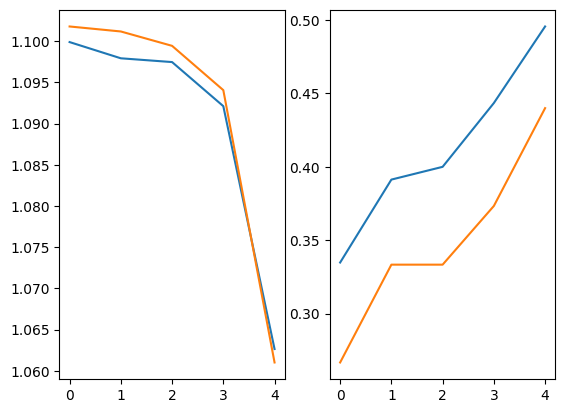

In [28]:
import matplotlib.pyplot as plt
# Setup a plot
# plt.figure(figsize=(6,10))

# Get number of epochs
epochs = range(len(model_1_df))

plt.subplot(1,2,1)
plt.plot(epochs, model_1_df['train_loss'])
plt.plot(epochs, model_1_df['test_loss'])

plt.subplot(1,2,2)
plt.plot(epochs, model_1_df['train_acc'])
plt.plot(epochs, model_1_df['test_acc'])
